# Binary Classification on the MIT-BIH Arrhythmia Dataset 
*Train a Float Neural Net on Float Data (balanced data)*

In [1]:
import h5py
from pathlib import Path
from copy import deepcopy

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
print(f'torch version: {torch.__version__}')

torch version: 1.8.1+cu102


Needed paths

In [3]:
project_path = Path.cwd().parent
project_path
train_path_x = project_path / 'data' / 'mit-bih' / 'csv' / 'mitbih_balanced_x_train.csv'
train_path_y = project_path / 'data' / 'mit-bih' / 'csv' / 'mitbih_balanced_bin_y_train.csv'
test_path_x = project_path / 'data' / 'mit-bih' / 'csv' / 'mitbih_balanced_x_test.csv'
test_path_y = project_path / 'data' / 'mit-bih' / 'csv' / 'mitbih_balanced_bin_y_test.csv'

## Dataset

In [4]:
class BalancedBinaryECG(Dataset):
    def __init__(self, 
                 train_path_x: Path, 
                 train_path_y: Path,
                 test_path_x: Path,
                 test_path_y: Path, 
                 train=True):
        if train:
            self.x = np.loadtxt(train_path_x, delimiter=",", dtype=float)
            self.x = torch.tensor(self.x, dtype=torch.float)
            self.x = torch.unsqueeze(self.x, 1)

            self.y = np.loadtxt(train_path_y, delimiter=",", dtype=float)
            self.y = torch.tensor(self.y)

        else:
            self.x = np.loadtxt(test_path_x, delimiter=",", dtype=float)
            self.x = torch.tensor(self.x, dtype=torch.float)
            self.x = torch.unsqueeze(self.x, 1)
            
            self.y = np.loadtxt(test_path_y, delimiter=",", dtype=float)
            self.y = torch.tensor(self.y)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
batch_size = 4
train_dataset = BalancedBinaryECG(train_path_x, train_path_y, test_path_x, test_path_y, train=True)
test_dataset = BalancedBinaryECG(train_path_x, train_path_y, test_path_x, test_path_y, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
print(train_dataset.x.shape)
print(train_dataset.y.shape)
print(test_dataset.x.shape)
print(test_dataset.y.shape)

torch.Size([6000, 1, 128])
torch.Size([6000])
torch.Size([6000, 1, 128])
torch.Size([6000])


torch.Size([1, 128])


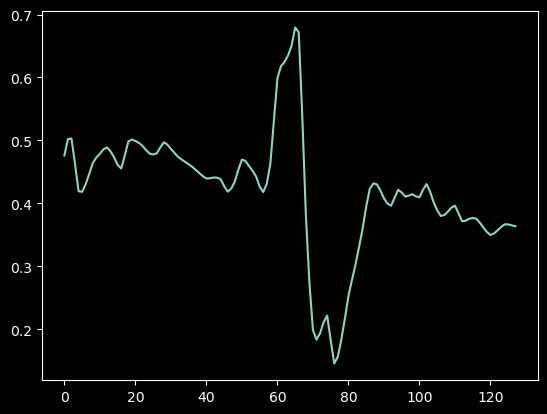

In [7]:
x0 = train_dataset.x[0]
print(x0.shape)
plt.plot(x0[0])

In [8]:
print(f"{train_dataset.y = }")

unique, train_counts = np.unique(train_dataset.y, return_counts=True)
print(f"there are {train_counts[0]} normal beats and {train_counts[1]} abnormal beats in the train dataset")
unique, test_counts = np.unique(test_dataset.y, return_counts=True)
print(f"there are {test_counts[0]} normal beats and {test_counts[1]} abnormal beats in the train dataset")

train_dataset.y = tensor([1., 1., 0.,  ..., 1., 1., 0.], dtype=torch.float64)
there are 3000 normal beats and 3000 abnormal beats in the train dataset
there are 3000 normal beats and 3000 abnormal beats in the train dataset


## Model

A simple linear regression model

In [9]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred

## Training

Set the parameters, random seed and the device.

In [10]:
epoch = 1000
lr = 0.001

In [11]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')


device: NVIDIA GeForce RTX 2060


Training and testing process

In [13]:
lr_model = LinearModel(128, 1)
lr_model.to(device)
print(lr_model)

def train(model):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for e in range(epoch):
        print(f"--------- epoch: {e+1} ---------")
        # training
        train_loss = 0.0
        corrects = 0
        total_examples = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()  # zero the gradients
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = model(x)
            y_pred = y_pred.reshape(y.shape)
            # the backward pass
            loss = criterion(y_pred, y)  # calculate the loss
            loss.backward()  # get the gradients
            optimizer.step()  # update the params based on the gradients
            # collect training results
            train_loss += loss.item()
            corrects += torch.sum((y_pred.round() == y))
            total_examples += len(y)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(corrects / total_examples)
        print(f"training loss = {train_losses[-1]:.4f}")
        print(f"training accuracy = {train_accuracies[-1]:.4f}")
        print(f"num_train_corrects / train_total_examples = {corrects.item()} / {total_examples}")
        # print(total_examples)

        # testing
        test_corrects = 0
        test_total_examples = 0
        with torch.no_grad():
            for i, (x, y) in enumerate(test_loader):
                # prepare data
                x = x.to(device)
                y = y.to(device).to(torch.float32)
                # the forward pass
                y_pred = model(x)
                y_pred = y_pred.reshape(y.shape)
                # collect testing results
                test_corrects += torch.sum((y_pred.round() == y))
                test_total_examples += len(y)

        test_accuracies.append(test_corrects.item() / test_total_examples)
        print(f"num_test_corrects / test_total_examples = {test_corrects.item()} / {test_total_examples}")
        print(f"testing accuracy = {test_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, test_accuracies

train_losses, train_accuracies, test_accuracies = train(lr_model)

LinearModel(
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
--------- epoch: 1 ---------
num_corrects / total_examples = 3409 / 6000
training loss = 0.6807
training accuracy = 0.5682
num_test_corrects / test_total_examples = 3205 / 6000
testing accuracy = 0.5342
--------- epoch: 2 ---------
num_corrects / total_examples = 3920 / 6000
training loss = 0.6525
training accuracy = 0.6533
num_test_corrects / test_total_examples = 3618 / 6000
testing accuracy = 0.6030
--------- epoch: 3 ---------
num_corrects / total_examples = 4116 / 6000
training loss = 0.6310
training accuracy = 0.6860
num_test_corrects / test_total_examples = 3933 / 6000
testing accuracy = 0.6555
--------- epoch: 4 ---------
num_corrects / total_examples = 4225 / 6000
training loss = 0.6140
training accuracy = 0.7042
num_test_corrects / test_total_examples = 3998 / 6000
testing accuracy = 0.6663
--------- epoch: 5 ---------
num_corrects / total_examples = 4285 / 6000
training loss 

Visualizing the results

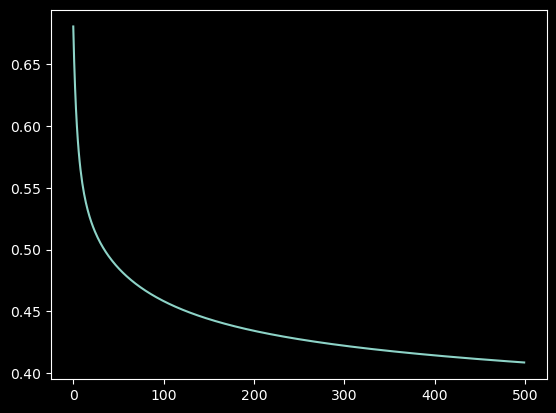

In [14]:
plt.plot(train_losses)

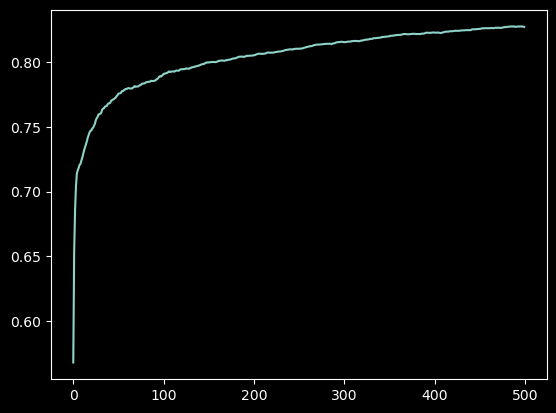

In [20]:
train_accuracies = [acc.cpu() for acc in train_accuracies]
plt.plot(train_accuracies)

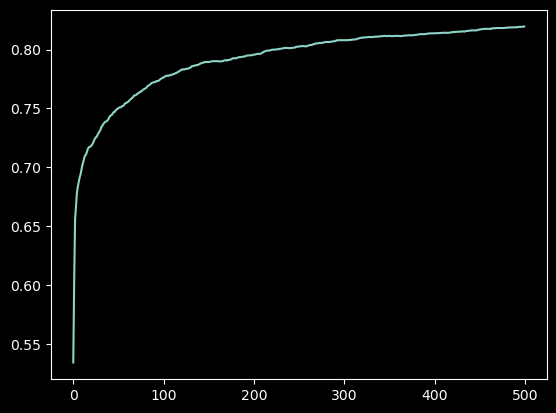

In [21]:
plt.plot(test_accuracies)

In [22]:
print(f"max train accuracy = {max(train_accuracies)}")
print(f"max test accuracy = {max(test_accuracies)}")

max train accuracy = 0.8273333311080933
max test accuracy = 0.8196666666666667


In [23]:
for param in lr_model.parameters():
    print(param)

Parameter containing:
tensor([[-7.2495e-01,  1.6174e-01, -6.5118e-01, -6.3574e-01, -6.2947e-01,
         -4.2108e-01, -2.8436e-01, -4.7996e-02,  6.8299e-02,  3.6998e-01,
          5.9276e-01,  8.2769e-01,  9.3473e-01,  1.0382e+00,  1.0796e+00,
          1.1081e+00,  1.0734e+00,  9.6020e-01,  7.0636e-01,  6.5817e-01,
          6.8697e-01,  6.9523e-01,  5.8685e-01,  6.8512e-01,  6.4985e-01,
          7.0368e-01,  7.8537e-01,  6.5624e-01,  6.4226e-01,  4.0647e-01,
          3.0501e-02, -2.3807e-01, -7.9140e-01, -1.2171e+00, -1.7221e+00,
         -2.3386e+00, -2.8535e+00, -3.0609e+00, -3.2898e+00, -3.2997e+00,
         -3.2672e+00, -3.3168e+00, -3.1674e+00, -3.0335e+00, -2.5445e+00,
         -1.5770e+00, -3.2493e-01,  8.5775e-01,  1.8803e+00,  2.6990e+00,
          3.3914e+00,  3.7812e+00,  4.2826e+00,  6.0460e+00,  7.5722e+00,
          7.6402e+00,  6.6095e+00,  2.7381e+00, -9.8366e-01, -1.8711e+00,
         -2.1034e+00, -3.5843e+00, -4.2217e+00, -1.0797e+00,  1.5913e+00,
          2.4595